# 4-2 数値解析（予測）

## 4-2-1 目的変数の例

## 4-2-2 データの加工

In [19]:
# ライブラリのインポート
import numpy as np
import pandas as pd
# 可視化用のライブラリ
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
# モデリング用のライブラリ
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

pd.set_option("display.max_columns", None)

In [2]:
# 学習用データの読み込み

df_train = pd.read_csv("../../support/src1300/src_ch04/4.2_予測/chapter42_data_train.csv")
print(df_train.shape)
display(df_train)

(100000, 22)


,id,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,target
0,0,0.082511,0.864454,1.752839,-0.025207,-0.199480,0.202334,0.308822,0.461498,-0.419892,-0.237371,0.497641,-0.120807,0.054095,0.108891,-1.812461,-0.380616,-1.425972,1.357266,-0.504612,-0.403779,55.925162
1,1,-1.579012,-1.657052,1.049626,0.324486,-0.755482,0.621993,-2.104844,-0.132732,-0.434696,-0.445537,2.846086,0.135825,0.252512,1.091540,-0.459219,2.035100,-1.022955,1.262619,-0.735285,-0.720626,66.637657
2,2,-0.230310,0.219643,1.777999,0.509717,0.750462,-0.398082,-1.092470,0.702629,0.644154,-1.049035,-0.072022,0.130316,-1.104487,-0.439381,0.425897,0.017224,-0.110650,-0.041120,-0.088200,2.178632,77.694937
3,3,-0.979686,-0.539392,-0.222426,-1.613728,0.033324,0.304396,1.175063,-0.362692,-0.480970,0.924335,1.594842,0.320425,-1.266707,-2.030257,-0.145011,-1.106305,0.650751,-0.406810,-1.356459,-0.636903,30.262566
4,4,2.079914,1.036572,-1.249453,0.278485,-1.370454,-1.876435,0.395299,0.153571,-0.958654,1.169482,0.073029,-2.043544,0.338650,-0.892215,0.248488,-0.739655,-0.771512,0.315995,-0.401172,0.421528,52.997912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,0.396308,-0.038937,-1.428462,-0.371332,0.350788,0.790414,-1.101408,-0.757437,0.588738,0.253354,0.269459,-0.252832,1.675286,1.748508,-0.577952,0.010787,1.233276,-2.212153,-0.994419,0.792027,58.378354
99996,99996,-1.866339,0.227198,-0.800749,0.279413,-0.357968,-2.041605,-0.852658,0.826998,1.975220,-0.061000,-0.335565,0.945068,0.802252,-1.114034,-0.052287,0.472044,1.811961,-0.569675,-0.795639,0.510338,61.210646
99997,99997,1.412660,2.092760,-1.389605,1.757515,-2.647794,-0.432071,-1.949836,-0.028525,-0.446924,0.036219,0.276549,-0.511629,0.484415,-0.747413,-1.131410,-0.303800,-0.833824,1.096805,-0.941216,1.777122,62.294123
99998,99998,-1.162195,1.956836,1.543994,-1.532670,0.242854,0.373051,0.804216,-1.763117,-0.426428,-0.240196,-0.191102,1.121079,-0.502738,2.784205,0.932559,0.520997,-1.044432,-1.329942,0.070106,1.324122,76.544133


In [4]:
# 目的変数と説明変数の分離

x, y = df_train.drop(columns=["target"]), df_train["target"]
print(x.shape)
print(y.shape)

(100000, 21)
(100000,)


### 4-2-3 データ分析・モデリング、および分析モデルの精度評価

- hold-out検証
  - 学習用データを学習用と検証用に分離して
  - 学習用データで分析モデルを作成
  - 検証用データで精度を評価する

In [5]:
# データを 8:2 に分割

idx_train = x.index[:80000]
idx_valid = x.index[80000:]

x_train, y_train = x.loc[idx_train, :], y.loc[idx_train]
x_valid, y_valid = x.loc[idx_valid, :], y.loc[idx_valid]

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(80000, 21) (80000,)
(20000, 21) (20000,)


In [6]:
# モデルパラメータの設定

params = {
    "boosting_type": "gbdt",
    "objective": "regression_l2",
    "learning_rate": 0.01,
    "metric": "rmse",
    "n_estimators": 10000,
    "num_leaves": 16,
    "max_depth": -1,
    "colsample_bytree": 0.8,
    "subsample": 0.9,
    "random_state": 123,
}
model = lgb.LGBMRegressor(**params)

In [7]:
# モデルの学習

model.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    early_stopping_rounds=100,
    verbose=200,
)
# 20s

/Users/takeru/@LEARNING/Python/data-analysis-textbook-ric/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/takeru/@LEARNING/Python/data-analysis-textbook-ric/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's rmse: 8.75101	valid_1's rmse: 8.76471
[400]	training's rmse: 6.4283	valid_1's rmse: 6.52875
[600]	training's rmse: 5.50103	valid_1's rmse: 5.65362
[800]	training's rmse: 5.14958	valid_1's rmse: 5.33257
[1000]	training's rmse: 5.0127	valid_1's rmse: 5.21486
[1200]	training's rmse: 4.95251	valid_1's rmse: 5.1674
[1400]	training's rmse: 4.92149	valid_1's rmse: 5.1483
[1600]	training's rmse: 4.90158	valid_1's rmse: 5.1418
[1800]	training's rmse: 4.88586	valid_1's rmse: 5.13926
[2000]	training's rmse: 4.87163	valid_1's rmse: 5.13834
[2200]	training's rmse: 4.85816	valid_1's rmse: 5.13791


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, metric='rmse',
              n_estimators=10000, num_leaves=16, objective='regression_l2',
              random_state=123, subsample=0.9)

In [8]:
# 学習モデルを用いて、予測値を算出

y_train_pred = model.predict(x_train)
y_valid_pred = model.predict(x_valid)

In [9]:
# 学習モデルの評価値（rmse）を算出

metric_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
metric_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

print(f"[rmse] train:{metric_train:.04f}, valid:{metric_valid:.04f}")

[rmse] train:4.8557, valid:5.1378


In [10]:
# 説明変数の重要度

df_imp = pd.DataFrame({
    "col": x_train.columns,
    "imp": model.feature_importances_
})
df_imp.sort_values("imp", ascending=False, ignore_index=True)

,col,imp
0,col17,3975
1,col18,3882
2,col4,3777
3,col14,3722
4,col15,3012
5,col20,2869
6,col3,2794
7,col19,2148
8,col10,825
9,col2,637


In [14]:
# テスト用データの読み込み

x_test = pd.read_csv("../../support/src1300/src_ch04/4.2_予測/chapter42_data_test_feature.csv")
y_test = pd.read_csv("../../support/src1300/src_ch04/4.2_予測/chapter42_data_test_target.csv")

In [17]:
print(x_test.shape)
display(x_test)

(20000, 21)


,id,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20
0,100000,-0.593587,0.738425,0.491772,0.226125,2.356071,0.664462,1.247649,-0.675037,0.528929,0.687351,-0.739765,-2.432715,1.210506,-1.011499,0.910955,2.243246,-0.517470,0.958629,-1.775211,0.679686
1,100001,0.987301,0.236974,-2.933571,-0.288675,2.043751,0.460938,0.452360,-1.525225,-0.296625,0.449359,-0.805976,-0.972635,-0.456614,-0.007506,0.013181,-0.311002,-0.090106,0.648101,-1.612070,-1.290563
2,100002,-0.778392,-0.086237,1.619731,-1.261252,-0.296038,-0.986359,1.412600,0.685879,0.350091,-0.063857,1.064072,0.547636,-0.327580,0.613588,-0.544156,0.701207,0.803612,-0.913500,0.592227,-0.343073
3,100003,0.500470,0.572618,-0.795521,-0.226336,-0.334852,-1.594219,-1.564270,-1.140098,0.439195,0.079189,1.088755,-0.798346,0.640173,-0.209182,1.029464,-0.884392,1.322247,0.480404,1.172885,1.182165
4,100004,-1.979629,1.258246,-1.976328,-1.678949,1.171683,0.446424,0.900259,-2.971732,1.253102,-1.805791,-0.133010,0.808517,0.866020,-0.694945,0.082420,0.586907,0.877474,-0.660718,-0.013500,0.398926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,119995,0.533130,-1.029567,2.300906,-0.441651,-0.350237,-1.441287,0.241544,0.355744,0.063846,0.892426,-0.412984,-0.035885,-0.296426,-0.489363,0.469257,-1.190864,-0.776700,1.449256,-1.560703,0.850792
19996,119996,-0.986470,2.117459,0.325830,-0.729952,-1.652917,-1.190178,-0.910772,1.668974,-0.138194,1.602147,0.443791,2.185924,-1.596875,0.186576,-2.100847,-0.546711,1.657371,0.454113,-1.551931,-1.413877
19997,119997,-0.557630,1.259775,0.134812,1.352846,-0.171577,-0.608834,0.523276,0.427775,0.539759,0.538237,0.418957,-0.069663,-0.135112,-0.643372,0.786475,0.591954,-0.371868,0.579966,0.869335,-0.241597
19998,119998,0.894804,1.254510,1.014596,-0.431353,0.314167,-0.834477,1.218408,-0.276294,-0.208869,0.479700,-0.822850,1.999550,-0.331944,1.372189,-0.427058,0.727865,-0.275175,0.019544,-1.089508,0.647586


In [16]:
print( y_test.shape)
display(y_test)

(20000, 1)


,target
0,56.575775
1,38.477494
2,68.122763
3,67.816458
4,41.126561
...,...
19995,56.537042
19996,55.404922
19997,70.971576
19998,65.600636


In [12]:
# 学習したモデルにテスト用データを入力して予測する

y_test_pred = model.predict(x_test)

In [13]:
# 評価値（rmse）を算出

print(f"[rmse] train:{np.sqrt(mean_squared_error(y_test, y_test_pred)):.04f}")

[rmse] train:5.0911


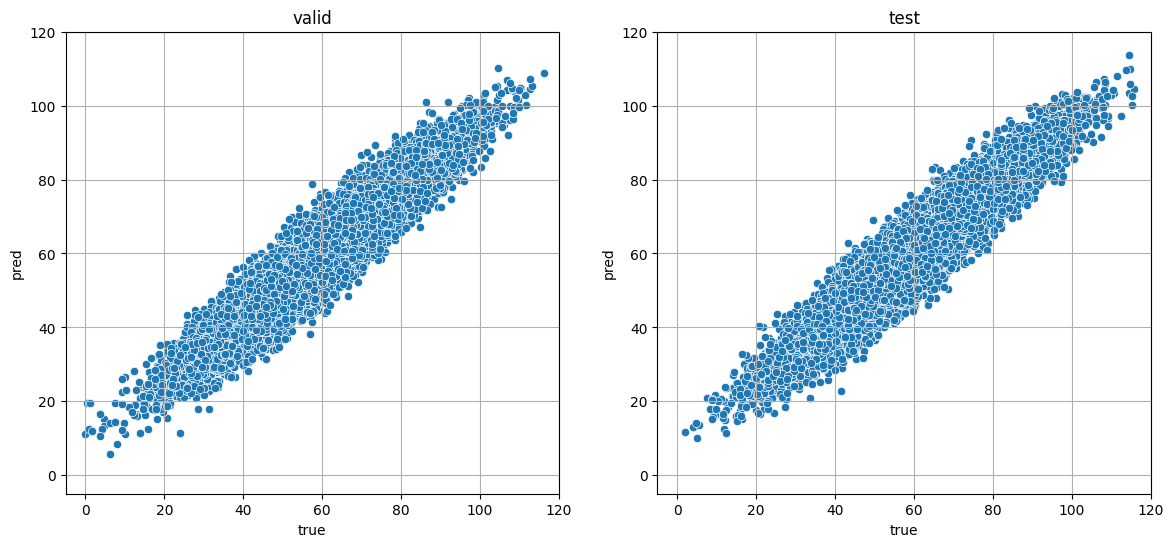

In [18]:
# 予測値と実績値の散布図

fig = plt.figure(figsize=(14, 6))

fig.add_subplot(1, 2, 1)
plt.title("valid")
sns.scatterplot(x=y_valid, y=y_valid_pred)
plt.xlim(-5, 120)
plt.ylim(-5, 120)
plt.xlabel("true")
plt.ylabel("pred")
plt.grid()

fig.add_subplot(1, 2, 2)
plt.title("test")
sns.scatterplot(x=y_test["target"], y=y_test_pred)
plt.xlim(-5, 120)
plt.ylim(-5, 120)
plt.xlabel("true")
plt.ylabel("pred")
plt.grid()

### 4-2-3 データ分析・モデリング、および分析モデルの精度評価

cross-validation 版

クロスバリデーションの設定

In [20]:
cv = list(
    KFold(n_splits=5, shuffle=True, random_state=123).split(x_train, y_train)
)
cv

[(array([    0,     1,     3, ..., 79996, 79997, 79998]),
  array([    2,     8,    20, ..., 79990, 79995, 79999])),
 (array([    0,     2,     3, ..., 79996, 79998, 79999]),
  array([    1,     5,     7, ..., 79986, 79988, 79997])),
 (array([    0,     1,     2, ..., 79997, 79998, 79999]),
  array([   19,    21,    28, ..., 79987, 79992, 79993])),
 (array([    0,     1,     2, ..., 79995, 79997, 79999]),
  array([    3,    10,    14, ..., 79991, 79996, 79998])),
 (array([    1,     2,     3, ..., 79997, 79998, 79999]),
  array([    0,     4,     6, ..., 79983, 79989, 79994]))]

In [27]:
len(cv)

5

In [29]:
len(cv[0])

2

In [31]:
len(cv[0][0]), len(cv[0][1])

(64000, 16000)

学習データを用いたモデル学習: クロスバリデーション

In [21]:
# 予測値を格納する行列の作成
train_oof = np.zeros(len(x_train))
train_oof

array([0., 0., 0., ..., 0., 0., 0.])

In [50]:
# 説明変数の重要度を格納するデータフレームの作成
df_imp = pd.DataFrame()

# 学習したモデルを格納するリストの作成
models = []

# 評価値を格納するリストの作成
metrics = []

In [51]:
# fold ごとにモデル学習処理を実行する
# 5-foldのため5回ループする
for nfold in np.arange(5):
    print("-"*10, nfold, "-"*10)
    # 学習用データと検証用データに分割する
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr]
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va]

    # モデルの定義
    params = {
        "boosting_type": "gbdt",
        "objective": "regression_l2",
        "learning_rate": 0.01,
        "metric": "rmse",
        "n_estimators": 10000,
        "num_leaves": 16,
        "max_depth": -1,
        "colsample_bytree": 0.8,
        "subsample": 0.9,
        "random_state": 123,
    }
    model = lgb.LGBMRegressor(**params)
    
    # モデルの学習
    model.fit(
        x_tr, y_tr,
        eval_set=[(x_tr, y_tr), (x_va, y_va)],
        early_stopping_rounds=100,
        verbose=1000,
    )
    # 学習したモデルの保存
    models.append(model)
    
    # 学習したモデルを用いて予測値を算出
    y_tr_pred = model.predict(x_tr)
    y_va_pred = model.predict(x_va)
    train_oof[idx_va] = y_va_pred
    
    # 評価値(rmse)の算出
    metric_tr = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    metric_va = np.sqrt(mean_squared_error(y_va, y_va_pred))
    # 評価値の保存
    metrics.append([nfold, metric_tr, metric_va])
    
    # 説明変数の重要度を保存する
    tmp_imp = pd.DataFrame({
        "nfold": nfold,
        "col": x_train.columns,
        "imp": model.feature_importances_
    })
    df_imp = pd.concat([df_imp, tmp_imp], axis=0)
# 2m

---------- 0 ----------


/Users/takeru/@LEARNING/Python/data-analysis-textbook-ric/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/takeru/@LEARNING/Python/data-analysis-textbook-ric/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	training's rmse: 4.99352	valid_1's rmse: 5.18796
[2000]	training's rmse: 4.83969	valid_1's rmse: 5.11133
---------- 1 ----------


/Users/takeru/@LEARNING/Python/data-analysis-textbook-ric/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/takeru/@LEARNING/Python/data-analysis-textbook-ric/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	training's rmse: 4.99344	valid_1's rmse: 5.21332
[2000]	training's rmse: 4.84219	valid_1's rmse: 5.11502
---------- 2 ----------


/Users/takeru/@LEARNING/Python/data-analysis-textbook-ric/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/takeru/@LEARNING/Python/data-analysis-textbook-ric/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	training's rmse: 4.98938	valid_1's rmse: 5.22676
[2000]	training's rmse: 4.83637	valid_1's rmse: 5.13949
---------- 3 ----------


/Users/takeru/@LEARNING/Python/data-analysis-textbook-ric/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/takeru/@LEARNING/Python/data-analysis-textbook-ric/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	training's rmse: 4.99087	valid_1's rmse: 5.23039
[2000]	training's rmse: 4.83622	valid_1's rmse: 5.14173
---------- 4 ----------


/Users/takeru/@LEARNING/Python/data-analysis-textbook-ric/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/takeru/@LEARNING/Python/data-analysis-textbook-ric/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	training's rmse: 4.97825	valid_1's rmse: 5.25195
[2000]	training's rmse: 4.82702	valid_1's rmse: 5.16467
[3000]	training's rmse: 4.74897	valid_1's rmse: 5.16007


In [40]:
# 評価値の集計
print("="*10, "result", "="*10)
metrics = np.array(metrics)
print(
    "[rmse] tr: {:.4f}+-{:.4f}, va: {:.4f}+-{:.4f}".format(
        metrics[:, 1].mean(), metrics[:, 1].std(),
        metrics[:, 2].mean(), metrics[:, 2].std(),
    )
)
print("[rmse] oof: {:.4f}".format(
    np.sqrt(mean_squared_error(y_train, train_oof)),
))

========== result ==========
[rmse] tr: 4.8013+-0.0299, va: 5.1328+-0.0183
[rmse] oof: 5.1329


In [52]:
# 説明変数の重要度の表示
df_imp

,nfold,col,imp
0,0,id,390
1,0,col1,353
2,0,col2,480
3,0,col3,2518
4,0,col4,3519
...,...,...,...
16,4,col16,1277
17,4,col17,4476
18,4,col18,4362
19,4,col19,2681


In [55]:
# 説明変数の重要度の集計
df_imp = df_imp.groupby("col")['imp'].mean()
df_imp = df_imp.astype(int)
df_imp = df_imp.reset_index(drop=False)
display(df_imp)

,col,imp
0,col1,643
1,col10,1041
2,col11,687
3,col12,813
4,col13,703
5,col14,3886
6,col15,3084
7,col16,756
8,col17,4027
9,col18,3899


テストデータの予測

In [56]:
# テスト用データの読み込み

x_test = pd.read_csv("../../support/src1300/src_ch04/4.2_予測/chapter42_data_test_feature.csv")
y_test = pd.read_csv("../../support/src1300/src_ch04/4.2_予測/chapter42_data_test_target.csv")

In [57]:
print(x_test.shape)
display(x_test)

(20000, 21)


,id,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20
0,100000,-0.593587,0.738425,0.491772,0.226125,2.356071,0.664462,1.247649,-0.675037,0.528929,0.687351,-0.739765,-2.432715,1.210506,-1.011499,0.910955,2.243246,-0.517470,0.958629,-1.775211,0.679686
1,100001,0.987301,0.236974,-2.933571,-0.288675,2.043751,0.460938,0.452360,-1.525225,-0.296625,0.449359,-0.805976,-0.972635,-0.456614,-0.007506,0.013181,-0.311002,-0.090106,0.648101,-1.612070,-1.290563
2,100002,-0.778392,-0.086237,1.619731,-1.261252,-0.296038,-0.986359,1.412600,0.685879,0.350091,-0.063857,1.064072,0.547636,-0.327580,0.613588,-0.544156,0.701207,0.803612,-0.913500,0.592227,-0.343073
3,100003,0.500470,0.572618,-0.795521,-0.226336,-0.334852,-1.594219,-1.564270,-1.140098,0.439195,0.079189,1.088755,-0.798346,0.640173,-0.209182,1.029464,-0.884392,1.322247,0.480404,1.172885,1.182165
4,100004,-1.979629,1.258246,-1.976328,-1.678949,1.171683,0.446424,0.900259,-2.971732,1.253102,-1.805791,-0.133010,0.808517,0.866020,-0.694945,0.082420,0.586907,0.877474,-0.660718,-0.013500,0.398926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,119995,0.533130,-1.029567,2.300906,-0.441651,-0.350237,-1.441287,0.241544,0.355744,0.063846,0.892426,-0.412984,-0.035885,-0.296426,-0.489363,0.469257,-1.190864,-0.776700,1.449256,-1.560703,0.850792
19996,119996,-0.986470,2.117459,0.325830,-0.729952,-1.652917,-1.190178,-0.910772,1.668974,-0.138194,1.602147,0.443791,2.185924,-1.596875,0.186576,-2.100847,-0.546711,1.657371,0.454113,-1.551931,-1.413877
19997,119997,-0.557630,1.259775,0.134812,1.352846,-0.171577,-0.608834,0.523276,0.427775,0.539759,0.538237,0.418957,-0.069663,-0.135112,-0.643372,0.786475,0.591954,-0.371868,0.579966,0.869335,-0.241597
19998,119998,0.894804,1.254510,1.014596,-0.431353,0.314167,-0.834477,1.218408,-0.276294,-0.208869,0.479700,-0.822850,1.999550,-0.331944,1.372189,-0.427058,0.727865,-0.275175,0.019544,-1.089508,0.647586


In [58]:
print(y_test.shape)
display(y_test)

(20000, 1)


,target
0,56.575775
1,38.477494
2,68.122763
3,67.816458
4,41.126561
...,...
19995,56.537042
19996,55.404922
19997,70.971576
19998,65.600636


In [59]:
# 予測値を格納する行列の作成
y_test_pred = np.zeros(len(x_test))

In [62]:
# 学習モデルを用いて予測する
for model in models:
    # 5-fold でモデルが5個あるため、予測値を 5 で割って合算する
    y_test_pred += model.predict(x_test) / len(models)

In [64]:
print(len(y_test_pred))
y_test_pred

20000


array([58.39681254, 44.42076909, 60.4579652 , ..., 67.46393875,
       65.52550541, 55.91374027])

In [65]:
# 評価値の算出
print("[rmse]: {:.4f}".format(
    np.sqrt(mean_squared_error(y_test, y_test_pred))
))

[rmse]: 5.0782


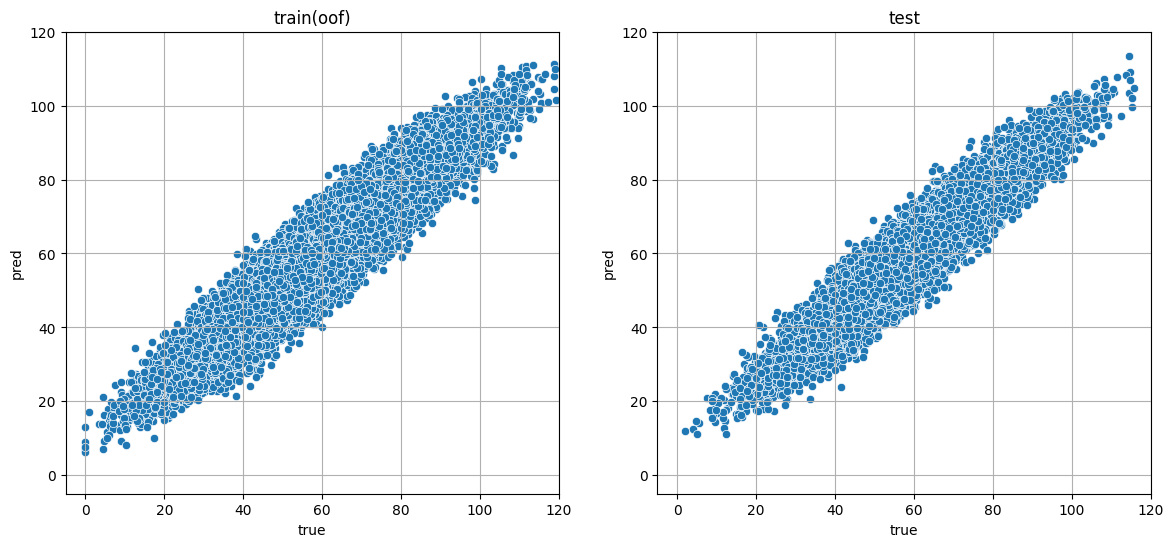

In [66]:
# 予測値と実績値の散布図

fig = plt.figure(figsize=(14, 6))

fig.add_subplot(1, 2, 1)
plt.title("train(oof)")
sns.scatterplot(x=y_train, y=train_oof)
plt.xlim(-5, 120)
plt.ylim(-5, 120)
plt.xlabel("true")
plt.ylabel("pred")
plt.grid()

fig.add_subplot(1, 2, 2)
plt.title("test")
sns.scatterplot(x=y_test["target"], y=y_test_pred)
plt.xlim(-5, 120)
plt.ylim(-5, 120)
plt.xlabel("true")
plt.ylabel("pred")
plt.grid()